# Inspect generated data

In [1]:
import os
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

from NeuroMotion.loaders import load_gen_data, load_sim_emg

sns.set_theme(style='whitegrid', font_scale=1.1)

In [2]:
def plot_rms_force_angle(data, bs, ax0, ax1, palette):
    
    # Plot force and angle
    color = 'tab:blue'
    ax0.plot(data['timestamps'], data['angle_profile'], color='grey', label='Angle')
    ax0.plot(data['timestamps'], data['force_profile'], color=color, label='Force')
    ax0.tick_params(axis='y', labelcolor=color)
    ax0.set_ylim([-5, 105])
    ax0.grid(False)

    # Create twin axs for RMS
    ax1.set_ylabel('RMS (mV)')  # we already handled the x-label with ax1
    ax1.plot(data['timestamps'], data['rms'], color=palette[bs], label=bs)
    ax1.tick_params(axis='y')
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('Time (s)')
    
    return ax0, ax1

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right')

# MUAPs

In [19]:
# Simulation properties
# ---------------------
muscle = 'FDSI'
num_mus = 100
mov_type = 'flx_ext'
sampling = 'default'
max_angle_flx, max_angle_ext = -65, 65
iters = np.arange(0,10).astype(int)

muap_angle_labels = np.linspace(max_angle_flx, max_angle_ext, sim['muaps'].shape[1]).astype(int)
idx_sel_angle = np.nonzero(muap_angle_labels == 0)[0][0]

In [25]:
# Load data
# ---------
props = ['num_fibres', 'cv', 'iz', 'angle', 'length', 'depth']
df_muap_props = pd.DataFrame()

for bs in iters:
    
    # Load data
    data_path = os.path.join(
        os.environ['HOME'], 
        'NeuroMotion', 'res',
        f'{muscle}_{mov_type}_{num_mus}mu_bs{bs}',
        f'sim_muaps_{sampling}_{muscle}_{num_mus}_{mov_type}_sample.hdf5'
    )
    sim = load_gen_data(data_path)
    
    # Get muaps at 0deg
    muap_angle_labels = np.linspace(max_angle_flx, max_angle_ext, sim['muaps'].shape[1]).astype(int)
    idx_0 = np.nonzero(muap_angle_labels == 0)[0][0]
    
    # Get properties into a dataframe
    curr_props = {key: sim['neural_params'][key][:, idx_0] for key in props}
    curr_props['bs'] = [bs] * num_mus
    curr_props['unit'] = np.arange(num_mus).astype(int)
    df_curr_props = pd.DataFrame(curr_props)
    
    # Combine dataframes
    df_muap_props = df_muap_props.append(df_curr_props, ignore_index=True)
    
# Fix column order
cols = deque(df_muap_props.columns.tolist())
cols.rotate(2)
df_muap_props = df_muap_props[cols]
display(df_muap_props)

,bs,unit,num_fibres,cv,iz,angle,length,depth
0,0,0,0.464311,0.542168,0.554133,0.578091,0.780878,0.854666
1,0,1,0.500054,0.546248,0.512837,0.612530,0.670471,0.889029
2,0,2,0.500054,0.566154,0.677591,0.598337,0.721382,0.870695
3,0,3,0.500054,0.577055,0.476342,0.580028,0.735823,0.955884
4,0,4,0.500054,0.588194,0.695265,0.609156,0.766182,0.994127
...,...,...,...,...,...,...,...,...
995,9,95,0.866669,0.986452,0.752559,0.583603,0.817713,0.875596
996,9,96,0.870707,1.009532,0.891215,0.583586,0.892324,0.937158
997,9,97,0.874569,1.034638,0.916287,0.578308,0.650513,0.894433
998,9,98,0.878670,1.046904,0.279541,0.609549,0.661755,0.902374


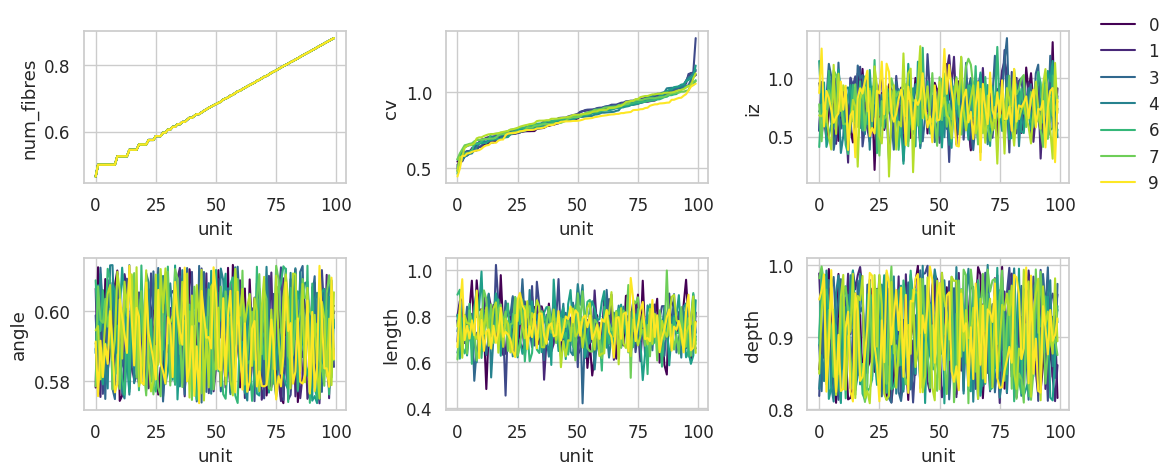

In [42]:
fig, axs = plt.subplots(2,3,figsize=(12,5),layout='tight')
axs = np.ravel(axs)

for i, prop in enumerate(props):
    if i == len(props)//2 -1:
        leg = 'auto'
    else:
        leg = False
        
    sns.lineplot(data=df_muap_props, x='unit', y=prop, hue='bs', palette='viridis', ax=axs[i], legend=leg)
    
    if leg:
        sns.move_legend(axs[i], "upper right", bbox_to_anchor=(1.4, 1.2), title=None, frameon=False)
    
plt.show()

# Static

In [8]:
muscle = 'FDSI'
excitations = np.arange(10,110,10).astype(int)
bs_iters = np.arange(0,10).astype(int)
noise = 25

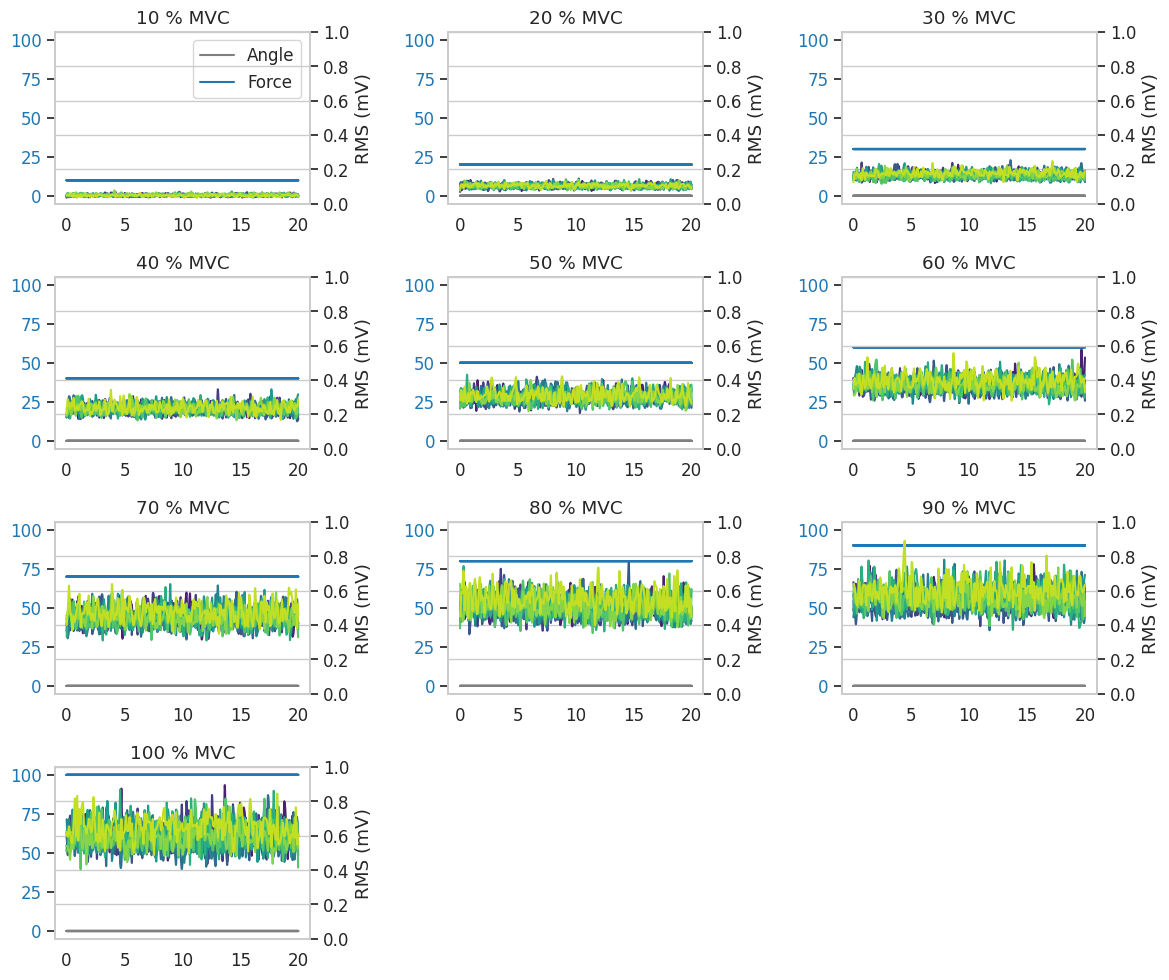

In [37]:
fig, axs = plt.subplots(4,3,figsize=(12, 10),layout='tight')
axs = np.ravel(axs)
palette = sns.color_palette("viridis", len(bs_iters))
verbose = False

for j, excitation in enumerate(excitations):
    
    ax0 = axs[j]
    ax0.set_title(f'{excitation} % MVC')
    ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
    if verbose: print(f'\nExcitation: {excitation} % MVC')
    
    for bs in bs_iters:
        # Load data
        data_path = os.path.join(
            os.environ['HOME'], 
            'NeuroMotion', 'res', 'static',
            f'semg_{muscle}_static_prepro_{excitation}mvc_25dB_bs{bs}.hdf5'
        )
        data = load_sim_emg(data_path)
        if verbose: print(f'\t{bs} iter - emg: {data["emg"].shape}')
        
        # Plot rms, force, angle
        ax0, ax1 = plot_rms_force_angle(data, bs, ax0, ax1, palette)
              
    if j == 0:
        legend_without_duplicate_labels(ax0)
    
axs[-1].set_axis_off()
axs[-2].set_axis_off()
plt.show()

# Noise

In [3]:
muscle = 'FDSI'
excitation = 30
bs_iters = np.arange(0,10).astype(int)
noise_levels = np.arange(30,5,-5)

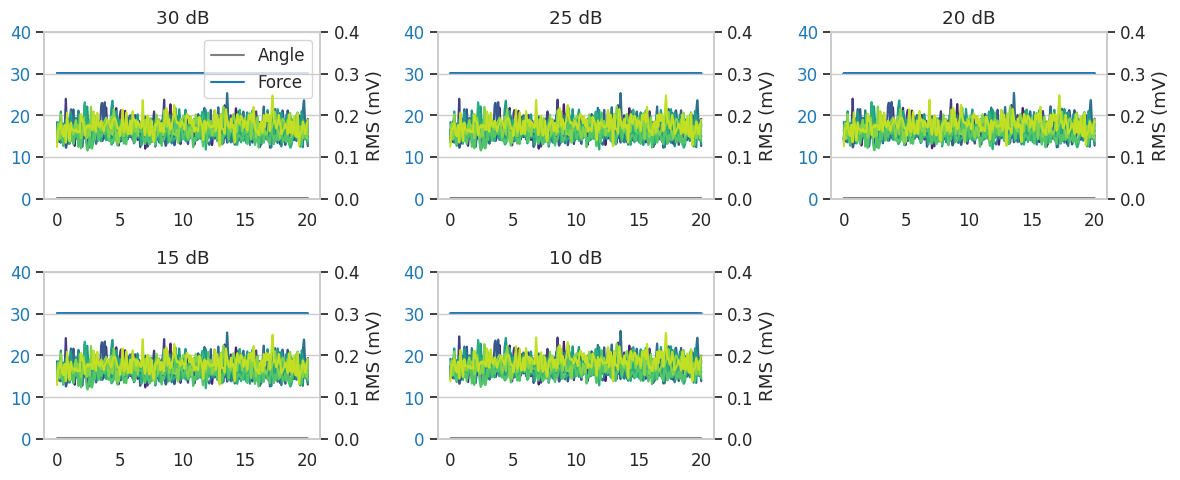

In [4]:
fig, axs = plt.subplots(2,3,figsize=(12, 5),layout='tight')
axs = np.ravel(axs)
palette = sns.color_palette("viridis", len(bs_iters))
verbose = False

for j, noise in enumerate(noise_levels):
    
    ax0 = axs[j]
    ax0.set_title(f'{noise} dB')
    ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
    if verbose: print(f'\nNoise: {noise} dB')
    
    for bs in bs_iters:
        # Load data
        data_path = os.path.join(
            os.environ['HOME'], 
            'NeuroMotion', 'res', 'static',
            f'semg_{muscle}_static_prepro_{excitation}mvc_{noise}dB_bs{bs}.hdf5'
        )
        data = load_sim_emg(data_path)
        if verbose: print(f'\t{bs} iter - emg: {data["emg"].shape}')
        
        # Plot rms, force, angle
        ax0, ax1 = plot_rms_force_angle(data, bs, ax0, ax1, palette)
        ax0.set_ylim([0, 40])
        ax1.set_ylim([0, 0.4])
                          
    if j == 0:
        legend_without_duplicate_labels(ax0)
    
axs[-1].set_axis_off()
plt.show()

# Ballistic

In [7]:
muscle = 'FDSI'
excitation = 40
bs_iters = np.arange(0,10).astype(int)
noise = 25

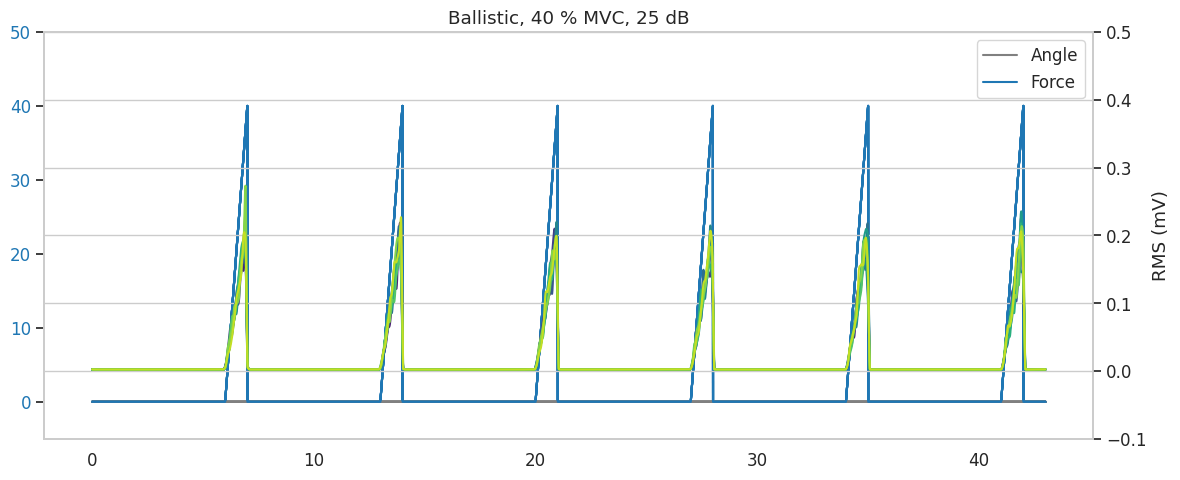

In [12]:
fig, axs = plt.subplots(1,1,figsize=(12, 5),layout='tight')
palette = sns.color_palette("viridis", len(bs_iters))
verbose = False

ax0 = axs
ax0.set_title(f'Ballistic, {excitation} % MVC, {noise} dB')
ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
if verbose: print(f'Ballistic: {excitation} % MVC')

for bs in bs_iters:
    # Load data
    data_path = os.path.join(
        os.environ['HOME'], 
        'NeuroMotion', 'res', 'ballistic',
        f'semg_{muscle}_ballistic_prepro_{excitation}mvc_{noise}dB_bs{bs}.hdf5'
    )
    data = load_sim_emg(data_path)
    if verbose: print(f'\t{bs} iter - emg: {data["emg"].shape}')

    # Plot rms, force, angle
    ax0, ax1 = plot_rms_force_angle(data, bs, ax0, ax1, palette)
    ax0.set_ylim([-5, 50])
    ax1.set_ylim([-0.1, 0.5])


legend_without_duplicate_labels(ax0)
plt.show()

# Chirp

In [14]:
muscle = 'FDSI'
excitation = 50
bs_iters = np.arange(0,10).astype(int)
noise = 25

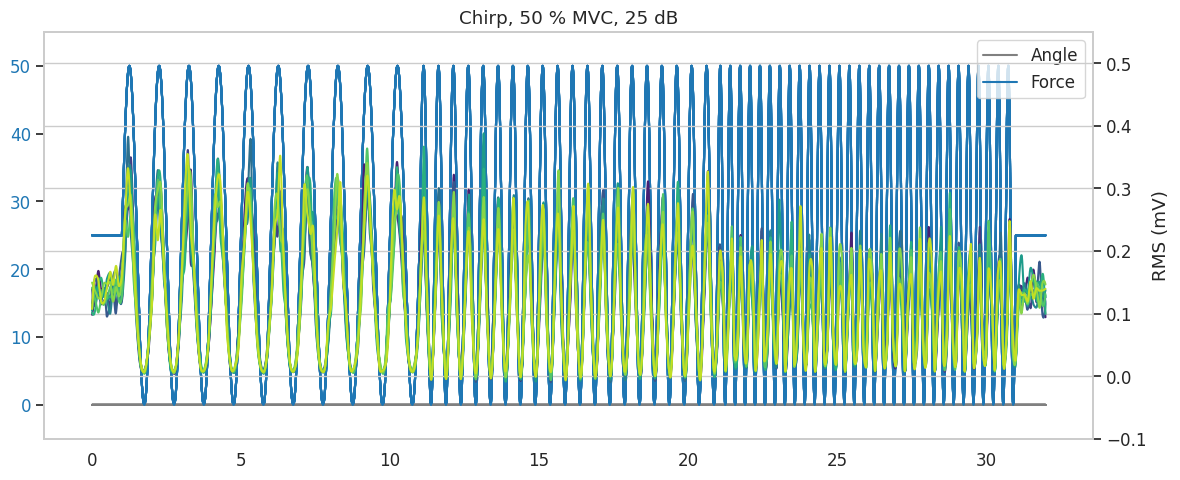

In [17]:
fig, axs = plt.subplots(1,1,figsize=(12, 5),layout='tight')
palette = sns.color_palette("viridis", len(bs_iters))
verbose = False

ax0 = axs
ax0.set_title(f'Chirp, {excitation} % MVC, {noise} dB')
ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
if verbose: print(f'Chirp: {excitation} % MVC')

for bs in bs_iters:
    # Load data
    data_path = os.path.join(
        os.environ['HOME'], 
        'NeuroMotion', 'res', 'chirp',
        f'semg_{muscle}_chirp_prepro_{excitation}mvc_{noise}dB_bs{bs}.hdf5'
    )
    data = load_sim_emg(data_path)
    if verbose: print(f'\t{bs} iter - emg: {data["emg"].shape}')

    # Plot rms, force, angle
    ax0, ax1 = plot_rms_force_angle(data, bs, ax0, ax1, palette)
    ax0.set_ylim([-5, 55])
    ax1.set_ylim([-0.1, 0.55])


legend_without_duplicate_labels(ax0)
plt.show()